In [1]:
import os
import pandas as pd
os.environ['TEJAPI_KEY'] = "your key"
os.environ['TEJAPI_BASE'] = "https://api.tej.com.tw"

In [2]:
import TejToolAPI 
from zipline.data import bundles
from logbook import Logger, StderrHandler, ERROR
from zipline.sources.TEJ_Api_Data import get_universe

log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=ERROR)
log_handler.push_application()
log = Logger('Algorithm')

In [3]:
start = '2020-01-01'
end = '2023-12-31'
pool = get_universe(start, end, mkt = ['TWSE', 'OTC'], stktp_c = '普通股')

os.environ['mdate'] = start + ' ' + end
os.environ['ticker'] = ' '.join(pool) + ' ' + 'IR0001'

Currently used TEJ API key call quota 77/100000 (0.08%)
Currently used TEJ API key data quota 18916186/10000000 (189.16%)


In [4]:
!zipline ingest -b tquant

Merging daily equity files:
Currently used TEJ API key call quota 84/100000 (0.08%)
Currently used TEJ API key data quota 23736643/10000000 (237.37%)


[2024-04-10 08:45:25.486494] INFO: zipline.data.bundles.core: Ingesting tquant.
[2024-04-10 08:49:38.876547] INFO: zipline.data.bundles.core: Ingest tquant successfully.


In [5]:
from zipline.api import *
from zipline.finance import commission, slippage

bundle_data = bundles.load('tquant')
universe = bundle_data.asset_finder.retrieve_all(bundle_data.asset_finder.equities_sids)   
tickers = [col.symbol for col in universe]

In [6]:
def initialize(context):
    set_slippage(slippage.VolumeShareSlippage(volume_limit = 0.025, price_impact = 0.1))
    set_commission(commission.Custom_TW_Commission(min_trade_cost = 20, discount = 1.0, tax = 0.003))
    set_benchmark(symbol('IR0001'))
    context.asset = [symbol(i) for i in tickers]
    context.rules = ['處置股票(Disposition Securities)']
    context.has_ordered = []

In [7]:
def before_trading_start(context, data):

    for ticker in context.asset: 
        annotation = data.current(ticker, 'annotation')
        #非處置股則不下單，且清空帳上股票
        if isinstance(annotation, str) and any(s in annotation for s in context.rules) and not ticker in context.has_ordered:
            order(ticker, 1000)
            context.has_ordered.append(ticker)
            
        elif ticker in context.has_ordered:
            order(ticker, 0)
            
        else:
            if ticker in set(context.portfolio.positions.keys()): # 當日前持有部位的股票標的
                order_target(ticker, 0)
                context.has_ordered.remove(ticker)

In [8]:
from zipline import run_algorithm
from zipline.utils.calendar_utils import get_calendar

start_date = pd.Timestamp(start, tz = 'utc')
end_date = pd.Timestamp(end, tz = 'utc')
capital_base = 1e7
calendar_name = 'TEJ'

results = run_algorithm(
    start = start_date,
    end = end_date,
    initialize=initialize,
    bundle='tquant',
    capital_base=capital_base,
    data_frequency='daily',
    before_trading_start = before_trading_start,
    trading_calendar=get_calendar(calendar_name)
)
results

,period_open,period_close,ending_exposure,starting_value,ending_value,starting_cash,benchmark_return,ending_cash,portfolio_value,returns,...,trading_days,benchmark_period_return,excess_return,benchmark_volatility,max_drawdown,algorithm_period_return,period_label,algo_volatility,treasury_period_return,sortino
2020-01-02 13:30:00+08:00,2020-01-02 09:01:00+08:00,2020-01-02 13:30:00+08:00,317800.00,0.00,317800.00,1.000000e+07,NaN,9.681730e+06,9.999530e+06,-0.000047,...,1,0.000000,-0.000047,NaN,-0.000047,-0.000047,2020-01,NaN,0.0,NaN
2020-01-03 13:30:00+08:00,2020-01-03 09:01:00+08:00,2020-01-03 13:30:00+08:00,428950.00,317800.00,428950.00,9.681730e+06,0.000823,9.567717e+06,9.996667e+06,-0.000286,...,2,0.000823,-0.001156,NaN,-0.000333,-0.000333,2020-01,0.002686,0.0,-12.895332
2020-01-06 13:30:00+08:00,2020-01-06 09:01:00+08:00,2020-01-06 13:30:00+08:00,425900.00,428950.00,425900.00,9.567717e+06,-0.012970,9.567717e+06,9.993617e+06,-0.000305,...,3,-0.012158,0.011520,0.154829,-0.000638,-0.000638,2020-01,0.002284,0.0,-13.897253
2020-01-07 13:30:00+08:00,2020-01-07 09:01:00+08:00,2020-01-07 13:30:00+08:00,428660.00,425900.00,428660.00,9.567717e+06,-0.006110,9.567717e+06,9.996377e+06,0.000276,...,4,-0.018194,0.017832,0.109481,-0.000638,-0.000362,2020-01,0.004306,0.0,-6.829002
2020-01-08 13:30:00+08:00,2020-01-08 09:01:00+08:00,2020-01-08 13:30:00+08:00,423200.00,428660.00,423200.00,9.567717e+06,-0.005322,9.567717e+06,9.990917e+06,-0.000546,...,5,-0.023419,0.022511,0.089596,-0.000908,-0.000908,2020-01,0.004937,0.0,-9.351730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25 13:30:00+08:00,2023-12-25 09:01:00+08:00,2023-12-25 13:30:00+08:00,39495218.30,39691611.37,39495218.30,-1.999072e+07,0.000466,-1.999072e+07,1.950450e+07,-0.009818,...,970,0.681222,0.269228,0.180693,-0.636566,0.950450,2023-12,0.417198,0.0,0.837042
2023-12-26 13:30:00+08:00,2023-12-26 09:01:00+08:00,2023-12-26 13:30:00+08:00,39954868.84,39495218.30,39954868.84,-1.999072e+07,0.008348,-1.999072e+07,1.996415e+07,0.023566,...,971,0.695256,0.301159,0.180643,-0.636566,0.996415,2023-12,0.417141,0.0,0.856170
2023-12-27 13:30:00+08:00,2023-12-27 09:01:00+08:00,2023-12-27 13:30:00+08:00,40071802.86,39954868.84,40071802.86,-1.999072e+07,0.007874,-1.999070e+07,2.008110e+07,0.005858,...,972,0.708604,0.299506,0.180588,-0.636566,1.008110,2023-12,0.416933,0.0,0.860589
2023-12-28 13:30:00+08:00,2023-12-28 09:01:00+08:00,2023-12-28 13:30:00+08:00,39963683.78,40071802.86,39963683.78,-1.999010e+07,0.001055,-2.001504e+07,1.994865e+07,-0.006596,...,973,0.710406,0.284459,0.180495,-0.636566,0.994865,2023-12,0.416737,0.0,0.854629


Start date,2020-01-02
End date,2023-12-29
Total months,46
,Backtest
Annual return,19.708%
Cumulative returns,100.426%
Annual volatility,41.653%
Sharpe ratio,0.64
Calmar ratio,0.31
Stability,0.16
Max drawdown,-63.657%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,63.66,2021-12-30,2022-10-26,2023-11-17,456
1,34.35,2021-04-08,2021-05-17,2021-12-22,180
2,13.33,2020-07-09,2020-07-28,2021-01-04,124
3,5.25,2021-02-22,2021-03-08,2021-03-15,15
4,5.16,2020-03-06,2020-03-23,2020-04-07,21


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial Unicode MS


Stress Events,mean,min,max
New Normal,0.11%,-13.70%,10.73%


Top 10 long positions of all time,max
sid,
3529,16.50%
8454,10.78%
6472,8.26%
6531,7.10%
6446,6.91%
6643,6.74%
6488,6.28%
2059,5.96%
6533,5.26%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
3529,16.50%
8454,10.78%
6472,8.26%
6531,7.10%
6446,6.91%
6643,6.74%
6488,6.28%
2059,5.96%
6533,5.26%


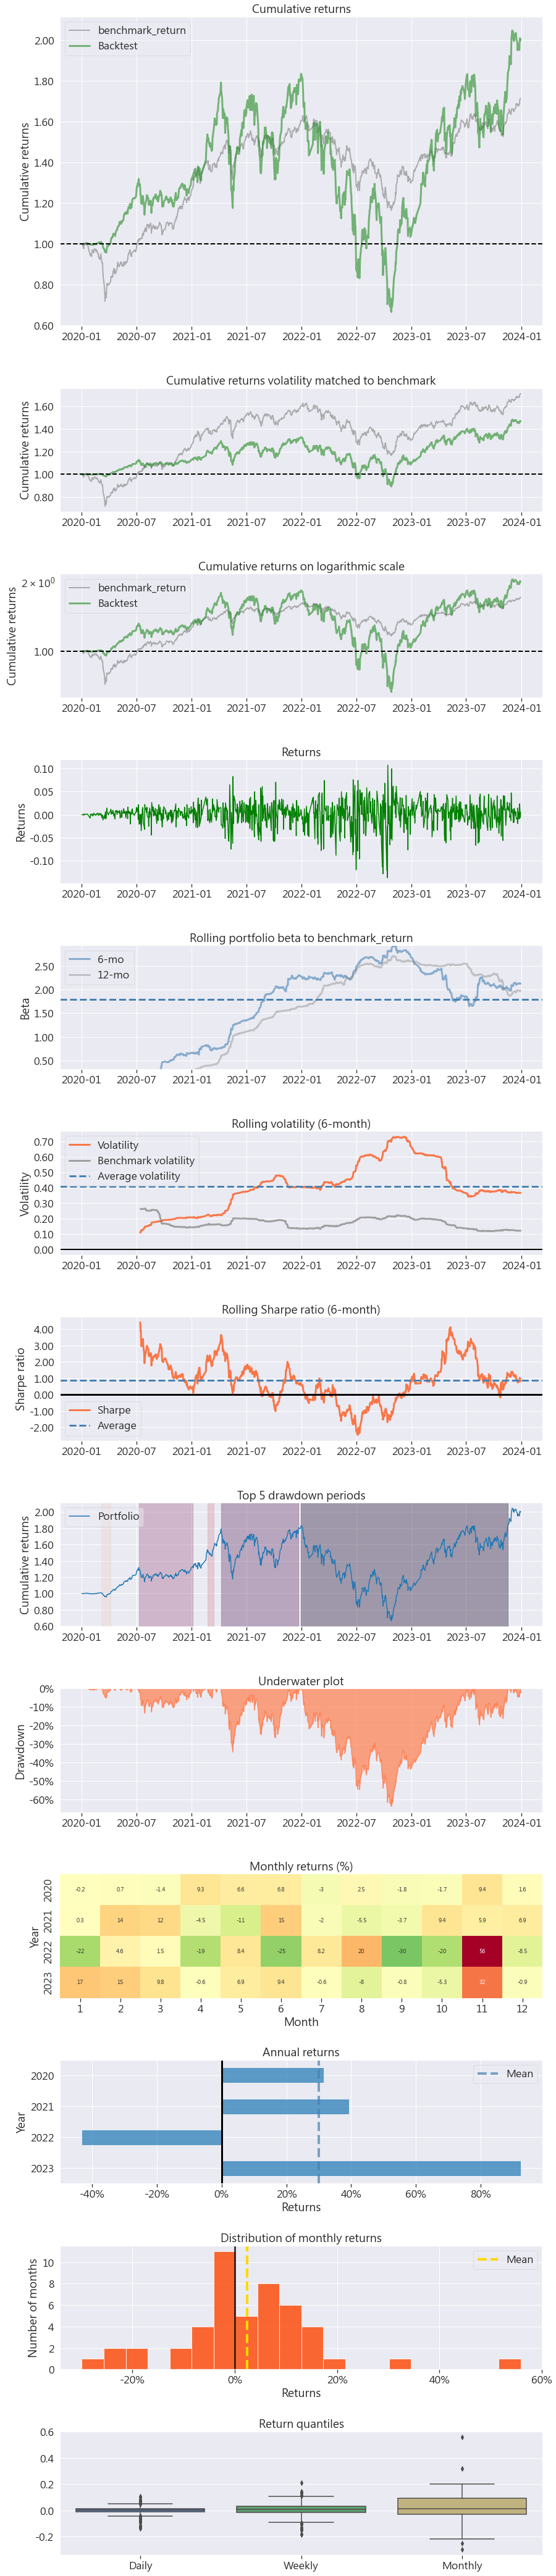

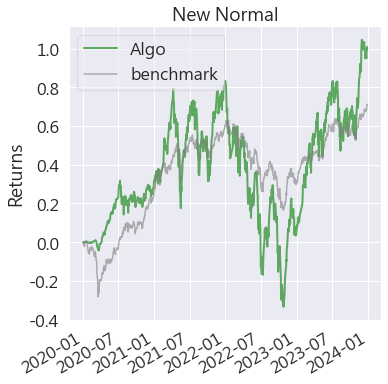

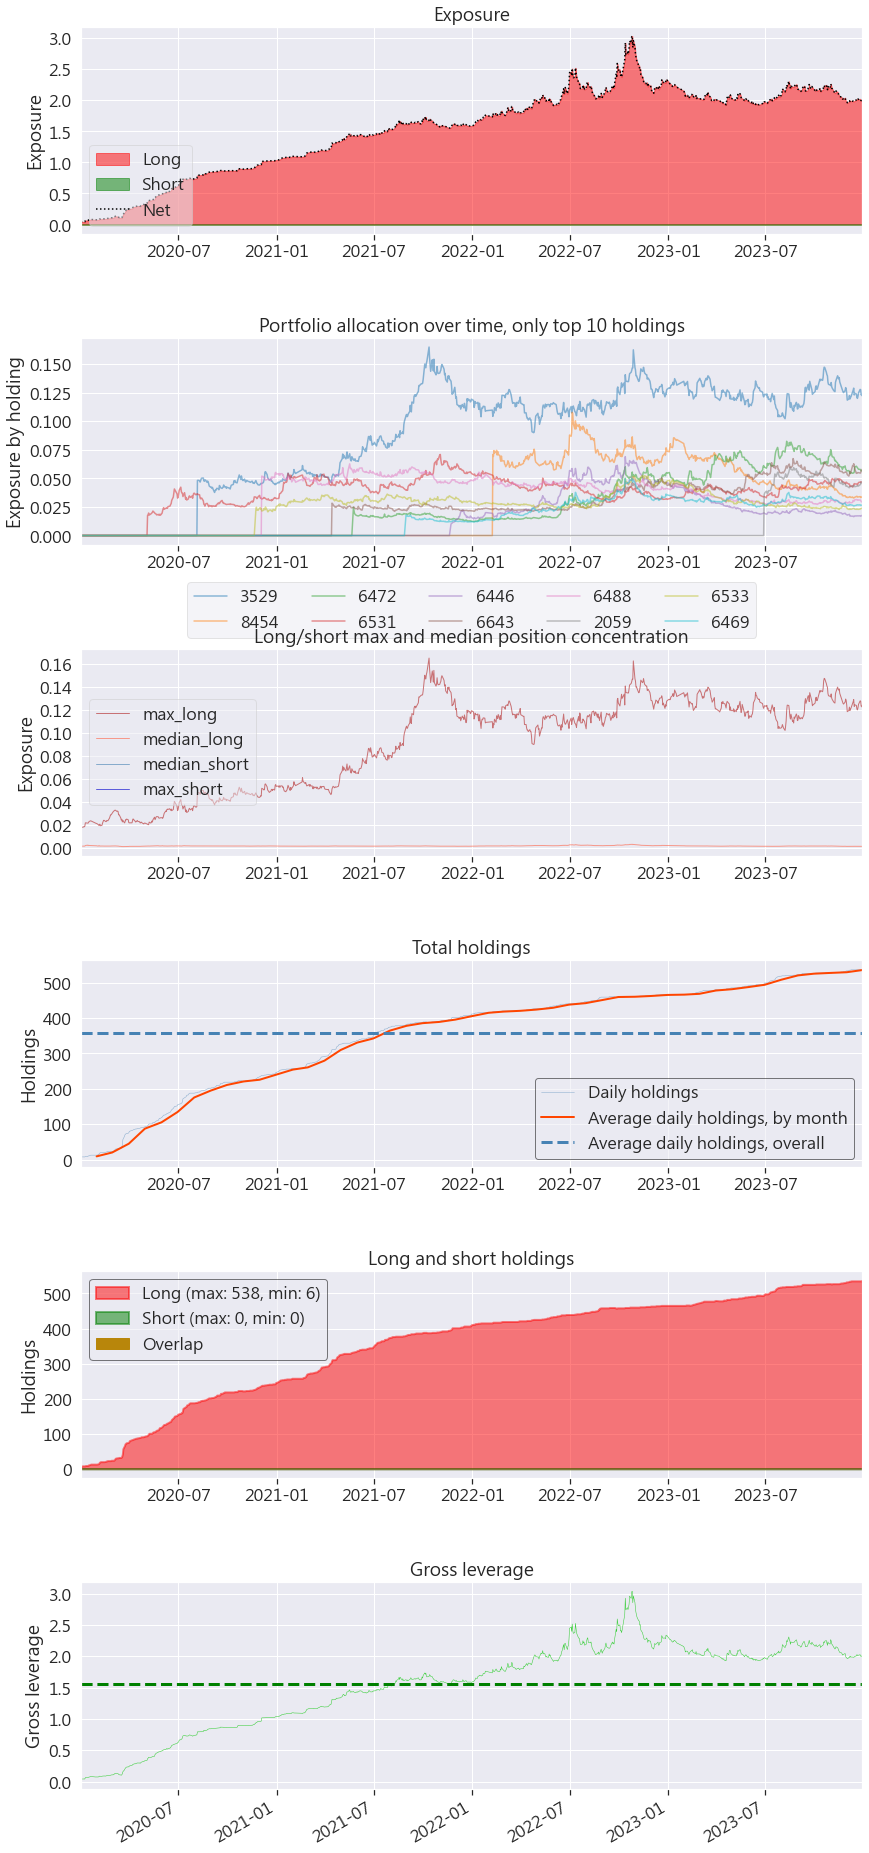

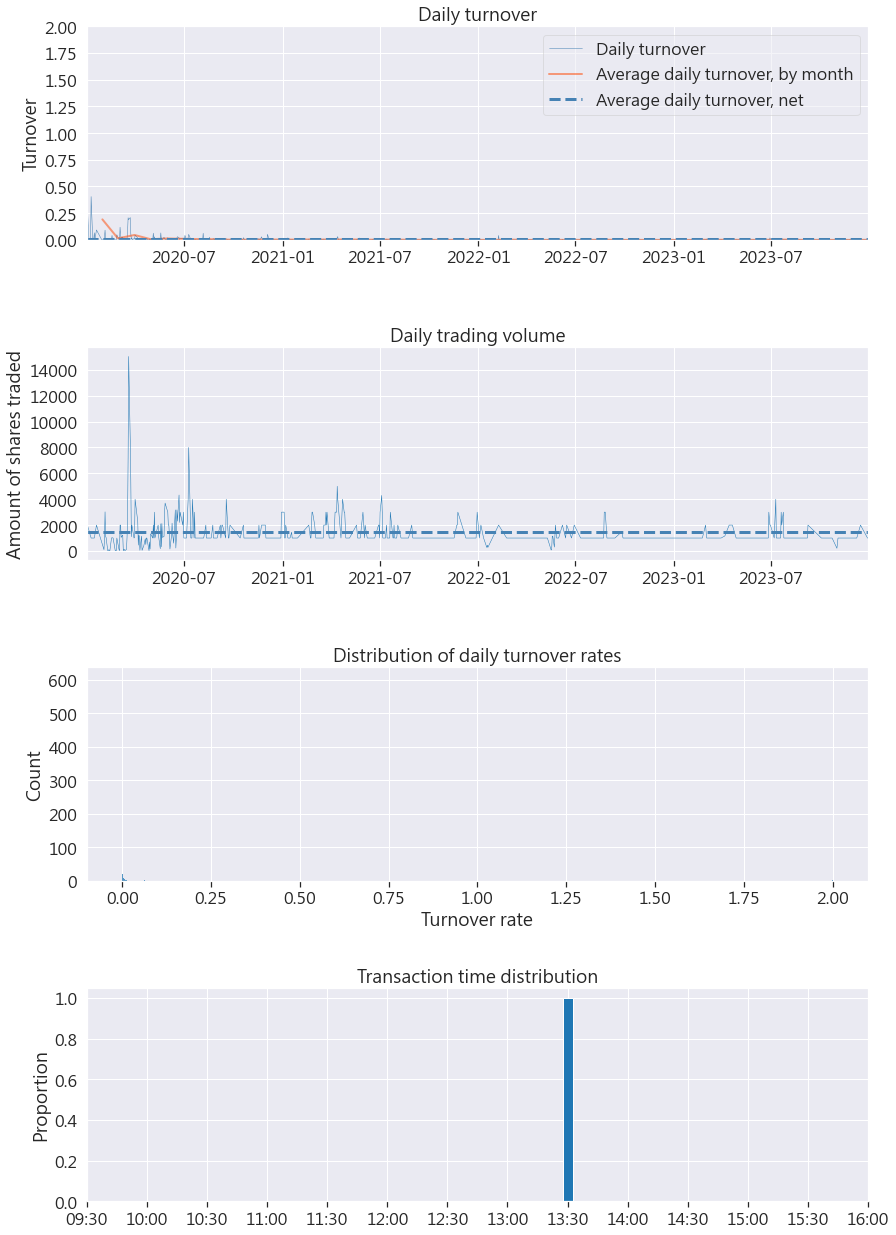

In [9]:
import pyfolio as pf
from pyfolio.utils import extract_rets_pos_txn_from_zipline

returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results.benchmark_return

# Creating a Full Tear Sheet
pf.create_full_tear_sheet(returns, positions = positions, transactions = transactions,
                          benchmark_rets = benchmark_rets,
                          round_trips=False)